In [2]:
import wptherml
from matplotlib import pyplot as plt
import numpy as np
import math

from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
import ovito
from ovito.pipeline import Pipeline
from ovito.vis import Viewport, TachyonRenderer




#Exciton Wavelength to Energy Conversion

#insert wavelength in nm here 
wvl = 370

#Constants and conversion factors
hp = 6.626 * 10 ** (-34)
ltspd = 2.998 * 10 ** 8
jtH = 2.294 * 10 ** 17

epsilon = (hp * ltspd / (wvl * 10 ** (-9))) * jtH


args = {  
'exciton_energy': epsilon, 
'aggregate_shape' : (10,0,0),
'displacement_between_monomers' : np.array([1, 0, 0]), 
'transition_dipole_moment' : np.array([0, 0, 0.5]) 
}  

sf = wptherml.SpectrumFactory()  
test = sf.spectrum_factory('Frenkel', args)
test.build_exciton_hamiltonian()

array([[1.23161438e-01, 3.30505819e-05, 5.60217206e-06, 3.75233992e-06],
       [3.30505819e-05, 1.23161438e-01, 3.75233992e-06, 5.60217206e-06],
       [5.60217206e-06, 3.75233992e-06, 1.23161438e-01, 3.30505819e-05],
       [3.75233992e-06, 5.60217206e-06, 3.30505819e-05, 1.23161438e-01]])

We will call the `compute_exciton_wavefunction_site_basis()`, which 
will evaluate the wavefunctions localized along the sites of each monomer as follows:

$$ \phi_n(x) = a \: {\rm exp}\left( -\frac{(x-x_n)^2}{2c^2} \right) $$

where $x_n$ is x-coordinate for the center of mass of exciton on site $n$.

In [3]:
test.compute_exciton_wavefunction_site_basis()

/Users/ptolley1/Documents/GitHub/wptherml/wptherml/exciton.py:314: RuntimeWarning: divide by zero encountered in scalar divide
  _a = 1 / (_c * np.sqrt(2 * np.pi))
/Users/ptolley1/Documents/GitHub/wptherml/wptherml/exciton.py:329: RuntimeWarning: divide by zero encountered in divide
  self.phi[:, n] = np.exp(-((self.x - _x_n) ** 2) / (2 * _c**2))
/Users/ptolley1/Documents/GitHub/wptherml/wptherml/exciton.py:329: RuntimeWarning: invalid value encountered in divide
  self.phi[:, n] = np.exp(-((self.x - _x_n) ** 2) / (2 * _c**2))


Calling this method also create a grid of $x$ values spanning values between `.x_min` and `.x_max`, which are derived
from the `.number_of_monomers` and `.displacement_between_monomers` attributes.

In [7]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
plt.close()

### parameters for plot
ax.set_xlim((test.x_min, test.x_max))
ax.set_ylim((0, 1))

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)
plt.show()
#plt.savefig("exciton_plot.png")

We can plot a few of these exciton wavefunctions as follows:

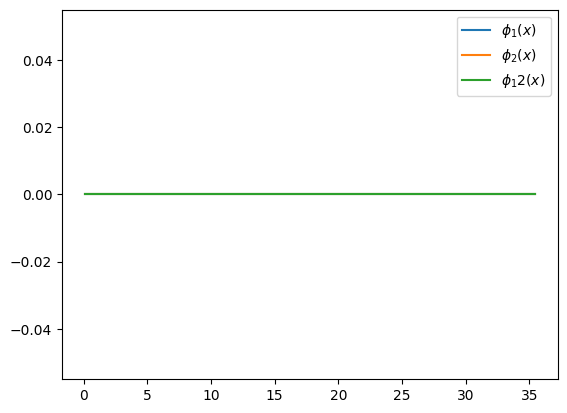

In [8]:
plt.plot(test.x, test.phi[:,0] ** 2, label="$\phi_1(x)$")
plt.plot(test.x, test.phi[:,1] ** 2, label="$\phi_2(x)$")
plt.plot(test.x, test.phi[:,0] * test.phi[:,1], label="$\phi_12(x)$")
#plt.plot(test.x, test.phi[:,3], label="$\phi_4(x)$")
plt.legend()
plt.show()

## RK method for Wavefunction $ \phi $

In [9]:
N_time = 100
t = np.zeros(N_time)


# animation function. This is called sequentially  
def animate(i):
    t = i / 10
    E = test._rk_exciton(0.5) #<== run your rk4 method here!
    
    y = np.zeros(len(test.phi[:,0]), dtype=complex)
    
    for j in range(test.number_of_monomers):
        for k in range(test.number_of_monomers):
            y[:] += test.c_vector[j] * test.phi[:,j] * test.c_vector[k] * test.phi[:,k]
            
    line.set_data(test.x, y)
    return (line,)
  

anim = animation.FuncAnimation(fig, animate, init_func=init,
                             frames=N_time, interval=100, blit=True)

# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim

/Users/ptolley1/miniforge3/envs/wptherml/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


## Mean Squared Displacement (MSD)

The trapezoid rule will be used to calculate the MSD:

$$ \langle{\Psi}|(\hat{X}-x_o)^2|\Psi\rangle = \langle{\Psi}|\hat{X}^2|\Psi\rangle - 2x_o\langle{\Psi}|\hat{X}|\Psi\rangle + x_o $$



$ x_o $ can be calculated as $ \langle{\Psi}|\hat{X}|\Psi\rangle $ at $ t = 0 s $

In [ ]:
dt = 0.0001
N_time = 100
msd1 = test.msd_density_matrix(dt, N_time)

In [ ]:
x = range(N_time)
y = msd1
plt.plot(x, y)
plt.show

## Diffusion Coefficient Calculations

In [ ]:
t_matrix = np.zeros((1, N_time))
for i in range(N_time):
    t_matrix[0,i] = i * dt

diff_coef = np.zeros((1, N_time))
for i in range(N_time):
    diff_coef[0,i] = msd1[i] / ( 2 * t_matrix[0,i])

actual_d1 = diff_coef[0,1]
actual_d2 = diff_coef[0,2]
actual_d3 = diff_coef[0,3]


expected_d1 = msd1[1] / (2 * t_matrix[0,1])
expected_d2 = msd1[2] / (2 * t_matrix[0,2])
expected_d3 = msd1[3] / (2 * t_matrix[0,3])

assert np.isclose(expected_d1, actual_d1)
assert np.isclose(expected_d2, actual_d2)
assert np.isclose(expected_d3, actual_d3)

The following animates the dynamics of a exciton wavefunction given for the chain of monomers that takes 
the form

\begin{equation}\tag{1}
P(x,t) = D_{11} \phi^2_1(x) + D_{12}\phi_1(x) \phi_2(x) + D_{21}\phi_2(x) \phi_1(x)  + D_{22}\phi^2_2(x),  
\end{equation}

where the elements of ${\bf D}$ are updated using `_rk_exciton_density_matrix(dt)`.  

This is equvalent to defining $P(x,t) = \Psi^*(x,t) \Psi(x,t)$ where 

\begin{align}\tag{2}
\Psi(x,t) &= c_1 \phi_1(x) + c_2 \phi_2(x) \\
\Psi^*(x,t) &= c^*_1 \phi_1(x) + c^*_2 \phi_2(x) \\
P(x,t) &= c^*_1 c_1 \phi_1^2(x) + c^*_1 c_2 \phi_1(x) \phi_2(x)  + c^*_2 c_1 \phi_2(x) \phi_1(x) + c^*_2 c_2 \phi_2^2(x).
\end{align}

Note that because $c^*_i c_j = c_j c^*_i = D_{ji}$ and $\phi_i(x) \phi_j(x) = \phi_j(x) \phi_i(x)$,
we can see that the definition of $P(x,t)$ in Eq. (1) is equivalent to $P(x,t)$ in Eq. (2).

In [ ]:
N_time = 500
t = np.zeros(N_time)


# animation function. This is called sequentially  
def animate(i):
    t = i / 10
    # _rk_exciton_density_matrix() does not return anything so you don't need an "E = " on the l.h.s.
    test._rk_exciton_density_matrix(0.5) #<== run your rk4 method here! use smallish timestep... ~ 0.01

    
    # trace of density matrix should be 1... if this assert statement fails, probably
    # means you need a smaller timestep for the Runge-Kutta integrator
    tr_d = np.trace(test.density_matrix)
    assert np.isclose(tr_d, 1.0)
    
    # initialize p to be an array of complex zeros
    # note the imaginary part should go to zero after summing up all
    # terms below but individual terms will be complex
    p = np.zeros(len(test.phi[:,0]), dtype=complex)
    
    for j in range(test.number_of_monomers):
        for k in range(test.number_of_monomers):
            p[:] += test.density_matrix[j, k] * test.phi[:,j] * test.phi[:,k]
    
    line.set_data(test.x, p)
    return (line,)
  

anim = animation.FuncAnimation(fig, animate, init_func=init,
                             frames=N_time, interval=100, blit=True)

# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim
anim.save('exciton_1.gif', dpi=500)#, save_all="true", loops=0)


In [ ]:
def animate(num_steps, dt):
    pipeline = Pipeline()
    # Create a particle property for position and color
    pipeline.source = ovito.data.Particles.create()
    pipeline.modifiers.append(self)

    # Set up the Ovito viewport and renderer
    viewport = Viewport()
    viewport.type = Viewport.Type.Orbit
    viewport.zoom_all()

    for step in range(num_steps):
        # Update the particle positions and other properties
        # Example: increment the X-coordinate of the first particle
        position = pipeline.source.particles['Position'].array
        position[0, 0] += dt
        pipeline.source.particles['Position'].array = position

        # Render the current frame
        viewport.display(pipeline)
        viewport.render_image(f"frame_{step}.png", size=(800, 600), renderer=TachyonRenderer())


In [ ]:
test.build_exciton_hamiltonian()

# Run the animation for 100 steps with a time step of 0.1
num_steps = 100
time_step = 0.1

animate(num_steps, time_step)
